## Final Project Submission

Please fill out:
* Student name: 
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import statsmodels.api as sm
import scipy.stats as stats

from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate

## Data Preparation

In [78]:
# Your code here - remember to use markdown cells for comments as well!
df = pd.read_csv('data/kc_house_data.csv')
df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,5/21/2014,360000.0,3,2.50,1530,1131,3.0,NO,NONE,...,8 Good,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509
21593,6600060120,2/23/2015,400000.0,4,2.50,2310,5813,2.0,NO,NONE,...,8 Good,2310,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200
21594,1523300141,6/23/2014,402101.0,2,0.75,1020,1350,2.0,NO,NONE,...,7 Average,1020,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007
21595,291310100,1/16/2015,400000.0,3,2.50,1600,2388,2.0,NaN,NONE,...,8 Good,1600,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287


In [79]:
# df = df.reset_index()
# encoder = OneHotEncoder()
# # apply on df
# # color_1hot = encoder.fit_transform(df_clean["zipcode"].values.reshape(-1,1))
# # color_1hot_df = pd.DataFrame(color_1hot.toarray())
# # df_clean = pd.concat([df_clean.drop('zipcode', axis = 1), color_1hot_df], axis = 1)
# zipcode_trans = encoder.fit_transform(df['zipcode'].values.reshape(-1,1))
# zipcode_trans.todense()
# encoder.get_feature_names()
# zipcode_df =pd.DataFrame(zipcode_trans.todense(), columns = encoder.get_feature_names())
# zipcode_df
# df = df.join(zipcode_df)
# df

In [80]:
df.duplicated().sum()


0

In [81]:
duplicates = df[df['id'].duplicated()]
print(len(duplicates))

177


In [82]:
df['id'].value_counts()

795000620     3
1825069031    2
2019200220    2
7129304540    2
1781500435    2
             ..
7812801125    1
4364700875    1
3021059276    1
880000205     1
1777500160    1
Name: id, Length: 21420, dtype: int64

In [83]:
df.loc[(df['id'] == 795000620 ) | 
      (df['id'] == 1825069031)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
3946,1825069031,8/14/2014,550000.0,4,1.75,2410,8447,2.0,NO,GOOD,...,8 Good,2060,350.0,1936,1980.0,98074,47.6499,-122.088,2520,14789
3947,1825069031,10/16/2014,550000.0,4,1.75,2410,8447,2.0,NaN,GOOD,...,8 Good,2060,350.0,1936,1980.0,98074,47.6499,-122.088,2520,14789
17588,795000620,9/24/2014,115000.0,3,1.00,1080,6250,1.0,NO,NONE,...,5 Fair,1080,0.0,1950,0.0,98168,47.5045,-122.330,1070,6250
17589,795000620,12/15/2014,124000.0,3,1.00,1080,6250,1.0,NO,NONE,...,5 Fair,1080,0.0,1950,0.0,98168,47.5045,-122.330,1070,6250
17590,795000620,3/11/2015,157000.0,3,1.00,1080,6250,1.0,NaN,NONE,...,5 Fair,1080,0.0,1950,NaN,98168,47.5045,-122.330,1070,6250


In [84]:
df['condition'].value_counts()

Average      14020
Good          5677
Very Good     1701
Fair           170
Poor            29
Name: condition, dtype: int64

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [86]:
training_data_ori = df.sample(frac = 0.75, random_state=25)
x_train_ori = training_data.drop('price', axis=1)
y_train_ori = training_data['price']

testing_data_ori = df.drop(training_data.index)
x_test_ori = testing_data.drop('price', axis =1)
y_test_ori = testing_data['price']

In [87]:
df_copy = df.copy()
df_copy

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,5/21/2014,360000.0,3,2.50,1530,1131,3.0,NO,NONE,...,8 Good,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509
21593,6600060120,2/23/2015,400000.0,4,2.50,2310,5813,2.0,NO,NONE,...,8 Good,2310,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200
21594,1523300141,6/23/2014,402101.0,2,0.75,1020,1350,2.0,NO,NONE,...,7 Average,1020,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007
21595,291310100,1/16/2015,400000.0,3,2.50,1600,2388,2.0,NaN,NONE,...,8 Good,1600,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287


In [88]:
df_copy = df_copy.drop_duplicates(subset= ['id'], keep = "last")
df_copy['id'].duplicated().sum()

0

In [89]:
df_copy['view'] = df_copy['view'].fillna(value="NONE")
df_copy['waterfront'] = df_copy['waterfront'].fillna(value="N/A")
df_copy['yr_renovated'] = df_copy['yr_renovated'].fillna(value= 0.0)
df_copy['sqft_basement'] = df_copy['sqft_basement'].apply(lambda x: x.replace("?", "0.0"))
df_copy['sqft_basement'] = df_copy['sqft_basement'].astype("float64")
df_copy['grade'] = df_copy["grade"].str.split(" ").str[0].astype('int64')


<ipython-input-89-6a013ca04471>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['view'] = df_copy['view'].fillna(value="NONE")
<ipython-input-89-6a013ca04471>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['waterfront'] = df_copy['waterfront'].fillna(value="N/A")
<ipython-input-89-6a013ca04471>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:/

In [90]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21420 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21420 non-null  int64  
 1   date           21420 non-null  object 
 2   price          21420 non-null  float64
 3   bedrooms       21420 non-null  int64  
 4   bathrooms      21420 non-null  float64
 5   sqft_living    21420 non-null  int64  
 6   sqft_lot       21420 non-null  int64  
 7   floors         21420 non-null  float64
 8   waterfront     21420 non-null  object 
 9   view           21420 non-null  object 
 10  condition      21420 non-null  object 
 11  grade          21420 non-null  int64  
 12  sqft_above     21420 non-null  int64  
 13  sqft_basement  21420 non-null  float64
 14  yr_built       21420 non-null  int64  
 15  yr_renovated   21420 non-null  float64
 16  zipcode        21420 non-null  int64  
 17  lat            21420 non-null  float64
 18  long  

In [91]:
df_copy["grade"].value_counts()

7     8889
8     6041
9     2606
6     1995
10    1130
11     396
5      234
12      88
4       27
13      13
3        1
Name: grade, dtype: int64

In [92]:
df_copy.loc[(df_copy['grade'] == 13) | (df_copy['grade'] == 3) | (df_copy["grade"] == 4)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
350,7325600160,6/4/2014,299000.0,1,0.75,560,12120,1.0,N/A,NONE,...,4,560,0.0,1967,0.0,98014,47.6750,-121.854,1300,19207
465,8658300340,5/23/2014,80000.0,1,0.75,430,5050,1.0,N/A,NONE,...,4,430,0.0,1912,0.0,98014,47.6499,-121.909,1200,7500
1065,3340401535,11/5/2014,140000.0,1,1.00,730,6890,1.0,NO,NONE,...,4,730,0.0,1926,0.0,98055,47.4670,-122.215,1790,7969
3220,2420069251,2/25/2015,262000.0,1,0.75,520,12981,1.0,NO,NONE,...,3,520,0.0,1920,0.0,98022,47.2082,-121.995,1340,12233
3578,1925069006,12/3/2014,355000.0,1,0.75,530,33278,1.0,NO,AVERAGE,...,4,530,0.0,1950,0.0,98074,47.6412,-122.079,2830,14311
3881,5279100625,4/29/2015,248000.0,2,1.00,770,8600,1.0,NO,NONE,...,4,770,0.0,1914,0.0,98027,47.5325,-122.031,1420,6960
4407,2470100110,8/4/2014,5570000.0,5,5.75,9200,35069,2.0,NO,NONE,...,13,6200,3000.0,2001,0.0,98039,47.6289,-122.233,3560,24345
4807,9831200500,3/4/2015,2480000.0,5,3.75,6810,7500,2.5,NO,NONE,...,13,6110,700.0,1922,0.0,98102,47.6285,-122.322,2660,7500
5199,4048400185,10/22/2014,352000.0,2,0.75,760,33801,1.0,NO,NONE,...,4,760,0.0,1931,0.0,98059,47.4703,-122.076,1100,39504
5446,7237501190,10/10/2014,1780000.0,4,3.25,4890,13402,2.0,NO,NONE,...,13,4890,0.0,2004,0.0,98059,47.5303,-122.131,5790,13539


In [93]:
df_copy = df_copy.loc[(df_copy['grade'] != 13) & (df_copy['grade'] != 3) & (df_copy["grade"] != 4)]

In [94]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21379 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21379 non-null  int64  
 1   date           21379 non-null  object 
 2   price          21379 non-null  float64
 3   bedrooms       21379 non-null  int64  
 4   bathrooms      21379 non-null  float64
 5   sqft_living    21379 non-null  int64  
 6   sqft_lot       21379 non-null  int64  
 7   floors         21379 non-null  float64
 8   waterfront     21379 non-null  object 
 9   view           21379 non-null  object 
 10  condition      21379 non-null  object 
 11  grade          21379 non-null  int64  
 12  sqft_above     21379 non-null  int64  
 13  sqft_basement  21379 non-null  float64
 14  yr_built       21379 non-null  int64  
 15  yr_renovated   21379 non-null  float64
 16  zipcode        21379 non-null  int64  
 17  lat            21379 non-null  float64
 18  long  

In [95]:
df_copy["condition"] = df_copy["condition"].apply(lambda x: x.replace("Poor", '1'))
df_copy["condition"] = df_copy["condition"].apply(lambda x: x.replace("Fair", '2'))
df_copy["condition"] = df_copy["condition"].apply(lambda x: x.replace("Average", '3'))
df_copy["condition"] = df_copy["condition"].apply(lambda x: x.replace("Very Good", '5'))
df_copy["condition"] = df_copy["condition"].apply(lambda x: x.replace("Good", '4'))

In [96]:
df_copy['condition'].value_counts()

3    13877
4     5631
5     1686
2      158
1       27
Name: condition, dtype: int64

In [97]:
df_copy['condition'] = df_copy["condition"].astype("int64")
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21379 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21379 non-null  int64  
 1   date           21379 non-null  object 
 2   price          21379 non-null  float64
 3   bedrooms       21379 non-null  int64  
 4   bathrooms      21379 non-null  float64
 5   sqft_living    21379 non-null  int64  
 6   sqft_lot       21379 non-null  int64  
 7   floors         21379 non-null  float64
 8   waterfront     21379 non-null  object 
 9   view           21379 non-null  object 
 10  condition      21379 non-null  int64  
 11  grade          21379 non-null  int64  
 12  sqft_above     21379 non-null  int64  
 13  sqft_basement  21379 non-null  float64
 14  yr_built       21379 non-null  int64  
 15  yr_renovated   21379 non-null  float64
 16  zipcode        21379 non-null  int64  
 17  lat            21379 non-null  float64
 18  long  

In [98]:
training_data = df_copy.sample(frac = 0.75, random_state=25)
x_train = training_data.drop('price', axis=1)
y_train = training_data['price']

testing_data = df_copy.drop(training_data.index)
x_test = testing_data.drop('price', axis =1)
y_test = testing_data['price']

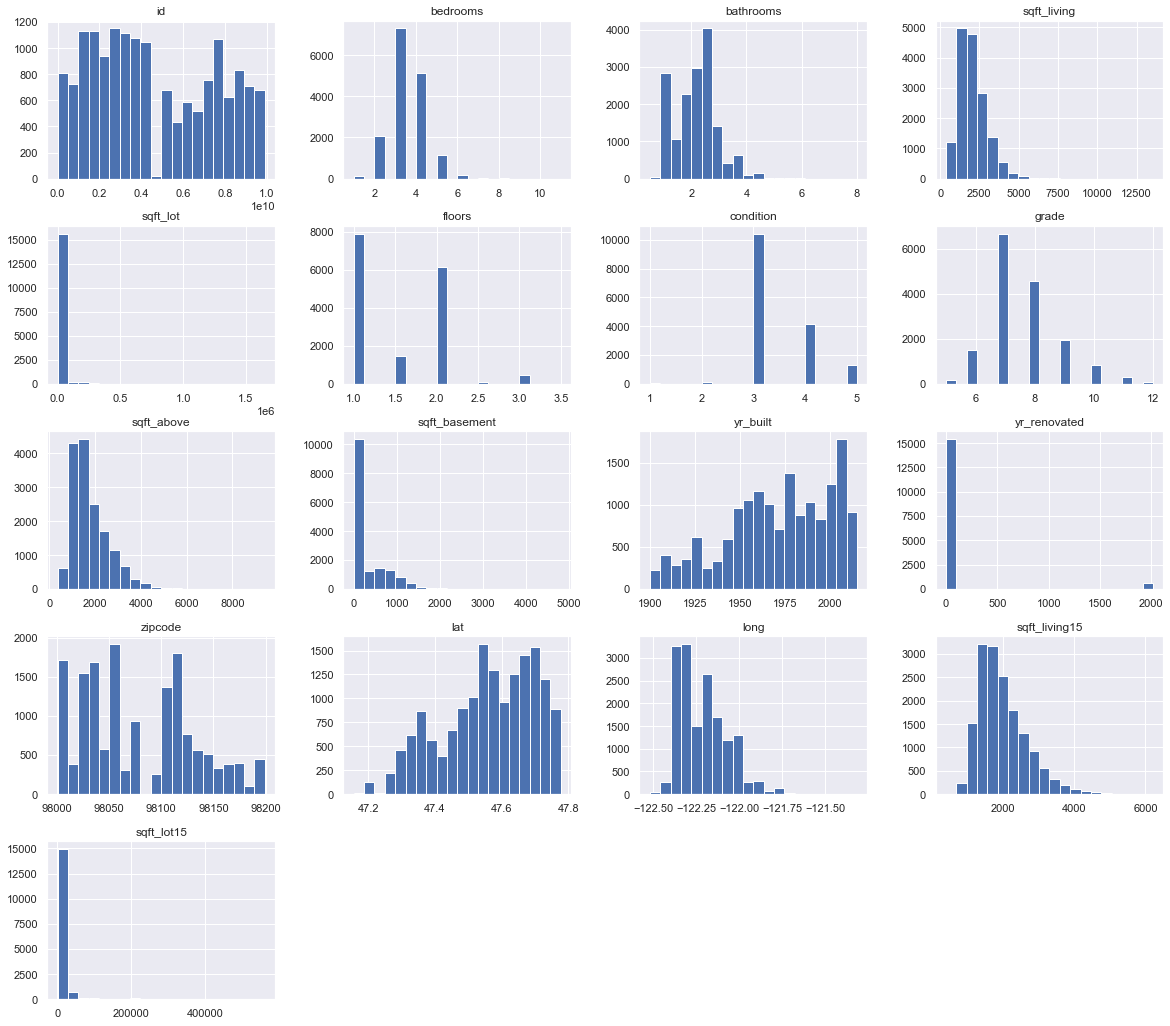

In [99]:
ax = x_train.hist(figsize = (20,18), bins=20)
plt.show()

<AxesSubplot:>

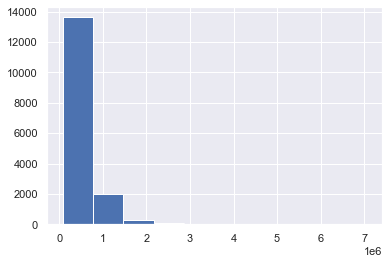

In [100]:
y_train.hist()

In [101]:
# y_train = np.log(y_train)
# y_train.hist()

## Model Construction

### Build a baseline Model

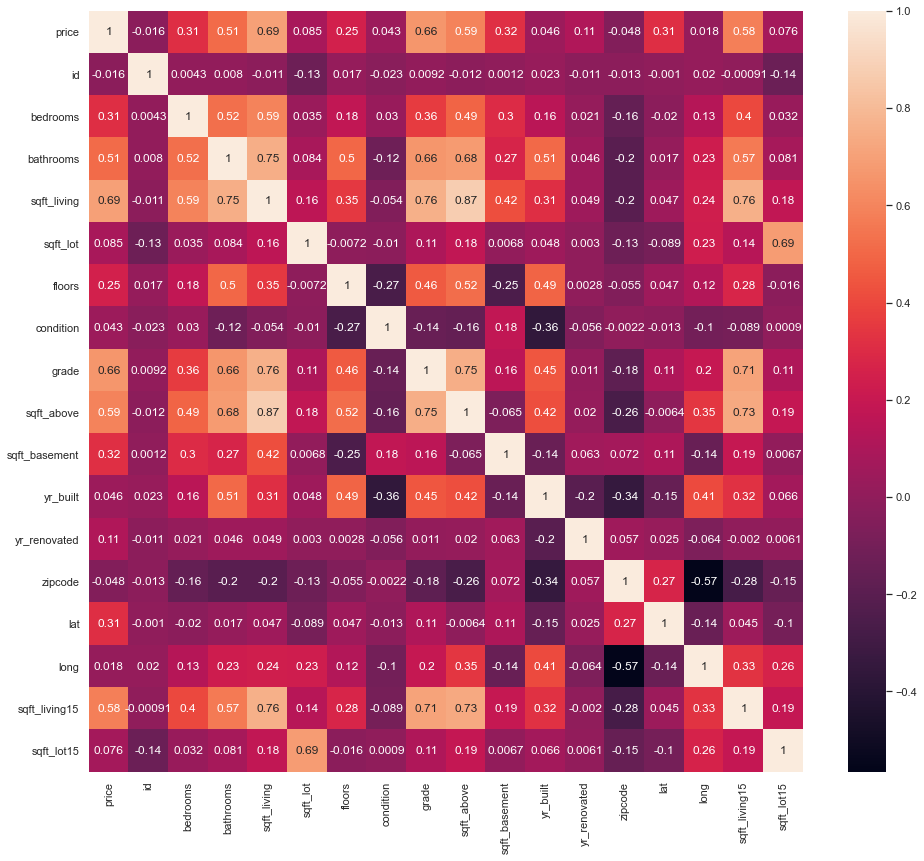

In [102]:
heatmap_data_ori = pd.concat([y_train_ori, x_train_ori], axis=1)
corr = heatmap_data_ori.corr()
sns.set(rc={'figure.figsize':(16, 14)})
sns.heatmap(data=corr, annot=True);

In [103]:
price_corrs = heatmap_data_ori.corr()['price'].map(abs).sort_values(ascending=False)
price_corrs

price            1.000000
sqft_living      0.694301
grade            0.663529
sqft_above       0.594850
sqft_living15    0.581384
bathrooms        0.513663
sqft_basement    0.316822
lat              0.312195
bedrooms         0.311858
floors           0.249015
yr_renovated     0.114851
sqft_lot         0.085157
sqft_lot15       0.076179
zipcode          0.048069
yr_built         0.045717
condition        0.043195
long             0.017696
id               0.015524
Name: price, dtype: float64

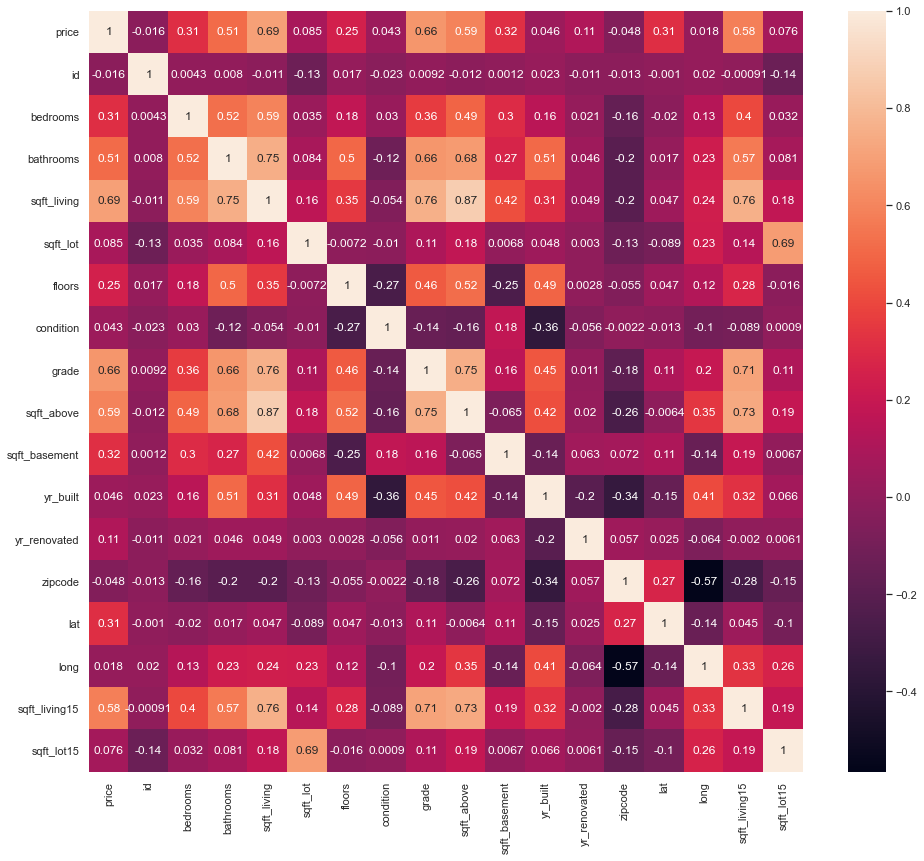

In [104]:
heatmap_data = pd.concat([y_train, x_train], axis=1)
corr = heatmap_data.corr()
sns.set(rc={'figure.figsize':(16, 14)})
sns.heatmap(data=corr, annot=True);

In [105]:
price_corrs = heatmap_data.corr()['price'].map(abs).sort_values(ascending=False)
price_corrs

price            1.000000
sqft_living      0.694301
grade            0.663529
sqft_above       0.594850
sqft_living15    0.581384
bathrooms        0.513663
sqft_basement    0.316822
lat              0.312195
bedrooms         0.311858
floors           0.249015
yr_renovated     0.114851
sqft_lot         0.085157
sqft_lot15       0.076179
zipcode          0.048069
yr_built         0.045717
condition        0.043195
long             0.017696
id               0.015524
Name: price, dtype: float64

In [107]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16034 entries, 581 to 88
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             16034 non-null  int64  
 1   date           16034 non-null  object 
 2   bedrooms       16034 non-null  int64  
 3   bathrooms      16034 non-null  float64
 4   sqft_living    16034 non-null  int64  
 5   sqft_lot       16034 non-null  int64  
 6   floors         16034 non-null  float64
 7   waterfront     16034 non-null  object 
 8   view           16034 non-null  object 
 9   condition      16034 non-null  int64  
 10  grade          16034 non-null  int64  
 11  sqft_above     16034 non-null  int64  
 12  sqft_basement  16034 non-null  float64
 13  yr_built       16034 non-null  int64  
 14  yr_renovated   16034 non-null  float64
 15  zipcode        16034 non-null  int64  
 16  lat            16034 non-null  float64
 17  long           16034 non-null  float64
 18  sqft_li

In [108]:
# house_preds = df[['sqft_living', 'sqft_above', 'sqft_living15', 'bathrooms']]
# house_target = df['price']
# lr = LinearRegression().fit(house_preds, house_target)
# lr.score(house_preds, house_target)
# ## multicollinear problem as 0.88, 0.76, 0.76 are pretty high

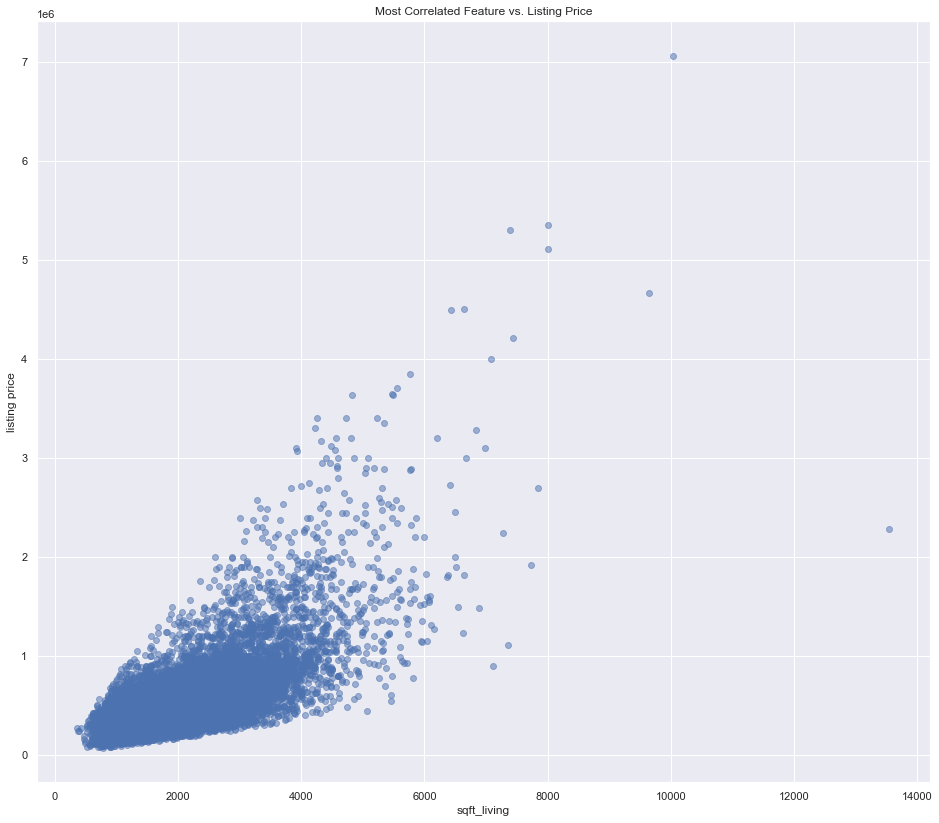

In [110]:
most_correlated_feature = "sqft_living"

fig, ax = plt.subplots()
ax.scatter(x_train[most_correlated_feature], y_train, alpha=0.5)
ax.set_xlabel(most_correlated_feature)
ax.set_ylabel("listing price")
ax.set_title("Most Correlated Feature vs. Listing Price");

In [111]:
baseline_model = LinearRegression()

In [113]:
from sklearn.model_selection import cross_validate, ShuffleSplit

splitter = ShuffleSplit(n_splits=3, test_size=0.75, random_state=0)

baseline_scores = cross_validate(
    estimator=baseline_model,
    X=x_train[[most_correlated_feature]],
    y=y_train,
    return_train_score=True,
    cv=splitter
)

print("Train score:     ", baseline_scores["train_score"].mean())
print("Validation score:", baseline_scores["test_score"].mean())

Train score:      0.487935626037261
Validation score: 0.4791669884733441


In [114]:
baseline_scores

{'fit_time': array([0.00299215, 0.00199485, 0.00199461]),
 'score_time': array([0.00199366, 0.0009973 , 0.00099754]),
 'test_score': array([0.4729787 , 0.48187999, 0.48264227]),
 'train_score': array([0.50184556, 0.48209545, 0.47986587])}

### Model with Only Numeric Features

In [115]:
x_train_numeric = x_train.select_dtypes("number").copy()
x_train_numeric

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
581,7511800070,3,1.50,1820,10608,1.0,4,7,1820,0.0,1962,0.0,98003,47.3366,-122.306,1380,8976
3478,3629870110,3,2.50,1910,3075,2.0,3,8,1910,0.0,2001,0.0,98029,47.5491,-122.005,1940,3485
950,9455200445,3,1.75,1330,6743,1.0,3,8,1330,0.0,1958,2002.0,98125,47.7012,-122.286,2600,7350
12913,3293700482,3,2.25,1780,9315,2.0,3,7,1780,0.0,1996,0.0,98133,47.7484,-122.353,1780,8545
15017,7129303070,4,2.75,3040,2415,2.0,3,8,3040,0.0,1966,0.0,98118,47.5188,-122.256,2620,2433
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9214,446000150,3,1.00,1100,5700,1.0,3,7,1100,0.0,1950,0.0,98115,47.6883,-122.282,1560,6588
16459,6600490250,4,2.50,2060,3608,2.0,3,7,2060,0.0,2004,0.0,98198,47.3620,-122.309,2060,3608
5110,3825500080,4,2.75,2310,7350,1.0,3,8,1670,640.0,1989,0.0,98011,47.7505,-122.182,2600,6077
12540,9284802825,2,1.75,1160,8625,1.0,4,6,1160,0.0,1941,0.0,98106,47.5509,-122.366,960,5750


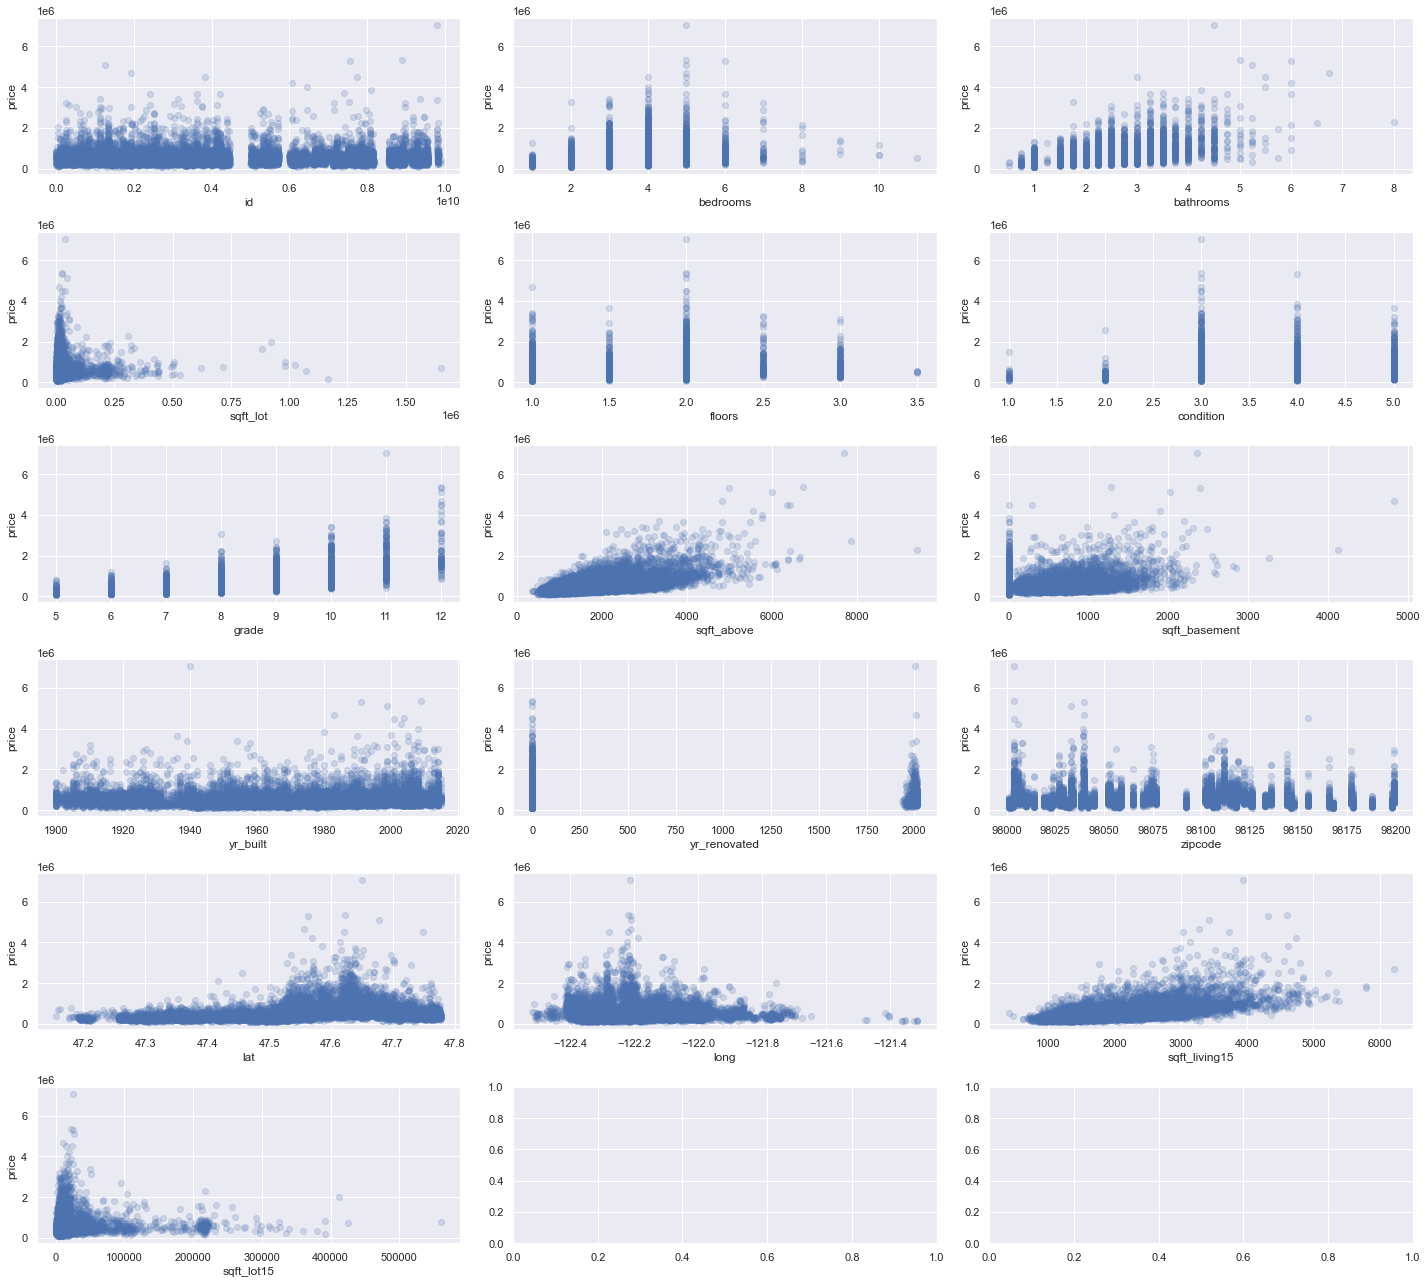

In [117]:
scatterplot_data = x_train_numeric.drop("sqft_living", axis=1)

fig, axes = plt.subplots(ncols=3, nrows=6, figsize=(20, 18))
fig.set_tight_layout(True)

for index, col in enumerate(scatterplot_data.columns):
    ax = axes[index//3][index%3]
    ax.scatter(x_train_numeric[col], y_train, alpha=0.2)
    ax.set_xlabel(col)
    ax.set_ylabel("price")

In [126]:
## drop id, 
x_train_second_model = x_train_numeric.drop('id', axis=1).copy()
x_train_second_model = x_train_numeric.drop('yr_renovated', axis=1).copy()
x_train_second_model = x_train_numeric.drop('sqft_basement', axis=1).copy()
x_train_second_model = x_train_numeric.drop('long', axis=1).copy()

x_train_second_model

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,sqft_living15,sqft_lot15
581,7511800070,3,1.50,1820,10608,1.0,4,7,1820,0.0,1962,0.0,98003,47.3366,1380,8976
3478,3629870110,3,2.50,1910,3075,2.0,3,8,1910,0.0,2001,0.0,98029,47.5491,1940,3485
950,9455200445,3,1.75,1330,6743,1.0,3,8,1330,0.0,1958,2002.0,98125,47.7012,2600,7350
12913,3293700482,3,2.25,1780,9315,2.0,3,7,1780,0.0,1996,0.0,98133,47.7484,1780,8545
15017,7129303070,4,2.75,3040,2415,2.0,3,8,3040,0.0,1966,0.0,98118,47.5188,2620,2433
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9214,446000150,3,1.00,1100,5700,1.0,3,7,1100,0.0,1950,0.0,98115,47.6883,1560,6588
16459,6600490250,4,2.50,2060,3608,2.0,3,7,2060,0.0,2004,0.0,98198,47.3620,2060,3608
5110,3825500080,4,2.75,2310,7350,1.0,3,8,1670,640.0,1989,0.0,98011,47.7505,2600,6077
12540,9284802825,2,1.75,1160,8625,1.0,4,6,1160,0.0,1941,0.0,98106,47.5509,960,5750


In [122]:
second_model = LinearRegression()

second_model_scores = cross_validate(
    estimator=second_model,
    X=x_train_second_model,
    y=y_train,
    return_train_score=True,
    cv=splitter
)

print("Current Model")
print("Train score:     ", second_model_scores["train_score"].mean())
print("Validation score:", second_model_scores["test_score"].mean())
print()
print("Baseline Model")
print("Train score:     ", baseline_scores["train_score"].mean())
print("Validation score:", baseline_scores["test_score"].mean())

Current Model
Train score:      0.6602659054583001
Validation score: 0.6498394416208922

Baseline Model
Train score:      0.487935626037261
Validation score: 0.4791669884733441


### select the best combinations of features

In [123]:
sm.OLS(y_train, sm.add_constant(x_train_second_model)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.654
Method:                 Least Squares   F-statistic:                     1896.
Date:                Tue, 10 May 2022   Prob (F-statistic):               0.00
Time:                        16:41:42   Log-Likelihood:            -2.1920e+05
No. Observations:               16034   AIC:                         4.384e+05
Df Residuals:                   16017   BIC:                         4.386e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.174e+06   3.49e+06     -0.336      0.737   -8.02e+06    5.68e+06
id             -1.24e-06    5.8e-07     -2.138      0.033   -2.38e-06   -1.03e-07
bedrooms      -4.593e+04   2389.910    -19.218      0.000   -5.06e+04   -4.12e+04
bathrooms      4.141e+04   3954.241     10.473      0.000    3.37e+04    4.92e+04
sqft_living     110.0425     23.355      4.712      0.000      64.265     155.820
sqft_lot          0.1108      0.055      2.008      0.045       0.003       0.219
floors         1.634e+04   4340.132      3.765      0.000    7832.591    2.48e+04
condition      2.949e+04   2829.417     10.422      0.000    2.39e+04     3.5e+04
grade          1.095e+05   2598.413     42.134      0.000    1.04e+05    1.15e+05
sqft_above       63.6261     23.275      2.734      0.006      18.004     109.249
sqft_basement    74.1670     23.138      3.205      0.001      28.813     119.521
yr_built      -3114.8704     83.854    -37.147      0.000   -3279.233   -2950.508
yr_renovated     32.5942      4.704      6.929      0.000      23.374      41.815
zipcode        -197.1866     35.780     -5.511      0.000    -267.320    -127.053
lat            5.441e+05   1.29e+04     42.208      0.000    5.19e+05    5.69e+05
sqft_living15    30.9557      4.108      7.536      0.000      22.904      39.008
sqft_lot15       -0.4414      0.090     -4.891      0.000      -0.618      -0.265
==============================================================================
Omnibus:                    14053.771   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1169158.633
Skew:                           3.824   Prob(JB):                         0.00
Kurtosis:                      44.128   Cond. No.                     1.15e+13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.15e+13. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [94]:
significant_features = ['bedrooms', 'bathrooms', 'sqft_living', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 
                        'yr_renovated', 'zipcode', 'lat', 'sqft_living15', 'sqft_lot15'] 

In [95]:
third_model = LinearRegression()
x_train_third_model = x_train[significant_features]

third_model_scores = cross_validate(
    estimator=third_model,
    X=x_train_third_model,
    y=y_train,
    return_train_score=True,
    cv=splitter
)

print("Current Model")
print("Train score:     ", third_model_scores["train_score"].mean())
print("Validation score:", third_model_scores["test_score"].mean())
print()
print("Second Model")
print("Train score:     ", second_model_scores["train_score"].mean())
print("Validation score:", second_model_scores["test_score"].mean())
print()
print("Baseline Model")
print("Train score:     ", baseline_scores["train_score"].mean())
print("Validation score:", baseline_scores["test_score"].mean())

Current Model
Train score:      0.6533379282710181
Validation score: 0.6473100506722766

Second Model
Train score:      0.6537000520661337
Validation score: 0.6466924974398253

Baseline Model
Train score:      0.49108895229656085
Validation score: 0.4851692639222354


### RFE approach

In [96]:
# Importances are based on coefficient magnitude, so
# we need to scale the data to normalize the coefficients
x_train_for_RFECV = StandardScaler().fit_transform(x_train_second_model)

model_for_RFECV = LinearRegression()

# Instantiate and fit the selector
selector = RFECV(model_for_RFECV, cv=splitter)
selector.fit(x_train_for_RFECV, y_train)

# Print the results
print("Was the column selected?")
for index, col in enumerate(x_train_second_model.columns):
    print(f"{col}: {selector.support_[index]}")

Was the column selected?
id: False
bedrooms: True
bathrooms: True
sqft_living: True
sqft_lot: False
floors: False
grade: True
sqft_above: True
yr_built: True
yr_renovated: True
zipcode: True
lat: True
long: True
sqft_living15: True
sqft_lot15: False


In [97]:
## drop the yr_build variable 
refined_features = ['bedrooms', 'bathrooms', 'sqft_living', 'grade', 'sqft_above', 'sqft_basement', 
                    'yr_built', 'zipcode', 'lat', 'long', 'sqft_living15'] 

In [98]:
fourth_model = LinearRegression()
x_train_fourth_model = x_train[refined_features]

fourth_model_scores = cross_validate(
    estimator=fourth_model,
    X=x_train_fourth_model,
    y=y_train,
    return_train_score=True,
    cv=splitter
)
print("Current Model")
print("Train score:     ", fourth_model_scores["train_score"].mean())
print("Validation score:", fourth_model_scores["test_score"].mean())
print()
print("Third Model")
print("Train score:     ", third_model_scores["train_score"].mean())
print("Validation score:", third_model_scores["test_score"].mean())
print()
print("Second Model")
print("Train score:     ", second_model_scores["train_score"].mean())
print("Validation score:", second_model_scores["test_score"].mean())
print()
print("Baseline Model")
print("Train score:     ", baseline_scores["train_score"].mean())
print("Validation score:", baseline_scores["test_score"].mean())

Current Model
Train score:      0.65193565876338
Validation score: 0.6470443364987691

Third Model
Train score:      0.6533379282710181
Validation score: 0.6473100506722766

Second Model
Train score:      0.6537000520661337
Validation score: 0.6466924974398253

Baseline Model
Train score:      0.49108895229656085
Validation score: 0.4851692639222354


In [99]:
from itertools import combinations

features = ['bedrooms', 'bathrooms', 'sqft_living', 'grade', 'sqft_above', 'sqft_basement', 
                    'yr_built', 'zipcode', 'lat', 'long', 'sqft_living15'] 

# Make a dataframe to hold the results (not strictly necessary
# but it makes the output easier to read)
results_df = pd.DataFrame(columns=features)

# Selecting just piece_count
results_df = results_df.append({
    "train_score": baseline_scores["train_score"].mean(),
    "val_score": baseline_scores["test_score"].mean()
}, ignore_index=True)

# Selecting 1 additional feature
for feature in features[1:]:
    scores = cross_validate(
        estimator=third_model,
        X=x_train[["sqft_living", feature]],
        y=y_train,
        return_train_score=True,
        cv=splitter
    )
    # Note: this technique of appending to a df is quite inefficient
    # Here it works because it's only happening 6 times, but avoid
    # doing this for a whole dataset
    results_df = results_df.append({
        feature: "Yes",
        "train_score": scores["train_score"].mean(),
        "val_score": scores["test_score"].mean()
    }, ignore_index=True)
    
# Selecting 2 additional features
for (feature1, feature2) in list(combinations(features[1:], 2)):
    scores = cross_validate(
        estimator=third_model,
        X=x_train[["sqft_living", feature1, feature2]],
        y=y_train,
        return_train_score=True,
        cv=splitter
    )
    results_df = results_df.append({
        feature1: "Yes",
        feature2: "Yes",
        "train_score": scores["train_score"].mean(),
        "val_score": scores["test_score"].mean()
    }, ignore_index=True)
    
for (feature1, feature2, feature3) in list(combinations(features[1:], 3)):
    scores = cross_validate(
        estimator=third_model,
        X=x_train[["sqft_living", feature1, feature2, feature3]],
        y=y_train,
        return_train_score=True,
        cv=splitter
    )
    results_df = results_df.append({
        feature1: "Yes",
        feature2: "Yes",
        feature3: "Yes",
        "train_score": scores["train_score"].mean(),
        "val_score": scores["test_score"].mean()
    }, ignore_index=True)  
    
for (feature1, feature2, feature3, feature4) in list(combinations(features[1:], 4)):
    scores = cross_validate(
        estimator=third_model,
        X=x_train[["sqft_living", feature1, feature2, feature3, feature4]],
        y=y_train,
        return_train_score=True,
        cv=splitter
    )
    results_df = results_df.append({
        feature1: "Yes",
        feature2: "Yes",
        feature3: "Yes",
        feature4: "Yes",
        "train_score": scores["train_score"].mean(),
        "val_score": scores["test_score"].mean()
    }, ignore_index=True)   
    
for (feature1, feature2, feature3, feature4, feature5) in list(combinations(features[1:], 5)):
    scores = cross_validate(
        estimator=third_model,
        X=x_train[["sqft_living", feature1, feature2, feature3, feature4, feature5]],
        y=y_train,
        return_train_score=True,
        cv=splitter
    )
    results_df = results_df.append({
        feature1: "Yes",
        feature2: "Yes",
        feature3: "Yes",
        feature4: "Yes",
        feature5: "Yes",
        "train_score": scores["train_score"].mean(),
        "val_score": scores["test_score"].mean()
    }, ignore_index=True)  
    
for (feature1, feature2, feature3, feature4, feature5, feature6) in list(combinations(features[1:], 6)):
    scores = cross_validate(
        estimator=third_model,
        X=x_train[["sqft_living", feature1, feature2, feature3, feature4, feature5, feature6]],
        y=y_train,
        return_train_score=True,
        cv=splitter
    )
    results_df = results_df.append({
        feature1: "Yes",
        feature2: "Yes",
        feature3: "Yes",
        feature4: "Yes",
        feature5: "Yes",
        feature6: "Yes",
        "train_score": scores["train_score"].mean(),
        "val_score": scores["test_score"].mean()
    }, ignore_index=True)  
    
for (feature1, feature2, feature3, feature4, feature5, feature6, feature7) in list(combinations(features[1:], 7)):
    scores = cross_validate(
        estimator=third_model,
        X=x_train[["sqft_living", feature1, feature2, feature3, feature4, feature5, feature6, feature7]],
        y=y_train,
        return_train_score=True,
        cv=splitter
    )
    results_df = results_df.append({
        feature1: "Yes",
        feature2: "Yes",
        feature3: "Yes",
        feature4: "Yes",
        feature5: "Yes",
        feature6: "Yes",
        feature7: "Yes",
        "train_score": scores["train_score"].mean(),
        "val_score": scores["test_score"].mean()
    }, ignore_index=True)  
    
for (feature1, feature2, feature3, feature4, feature5, feature6, feature7, feature8) in list(combinations(features[1:], 8)):
    scores = cross_validate(
        estimator=third_model,
        X=x_train[["sqft_living", feature1, feature2, feature3, feature4, feature5, feature6, feature7, feature8]],
        y=y_train,
        return_train_score=True,
        cv=splitter
    )
    results_df = results_df.append({
        feature1: "Yes",
        feature2: "Yes",
        feature3: "Yes",
        feature4: "Yes",
        feature5: "Yes",
        feature6: "Yes",
        feature7: "Yes",
        feature8: "Yes",
        "train_score": scores["train_score"].mean(),
        "val_score": scores["test_score"].mean()
    }, ignore_index=True)  
    
for (feature1, feature2, feature3, feature4, feature5, feature6, feature7, feature8, feature9) in list(combinations(features[1:], 9)):
    scores = cross_validate(
        estimator=third_model,
        X=x_train[["sqft_living", feature1, feature2, feature3, feature4, feature5, feature6, feature7, feature8, feature9]],
        y=y_train,
        return_train_score=True,
        cv=splitter
    )
    results_df = results_df.append({
        feature1: "Yes",
        feature2: "Yes",
        feature3: "Yes",
        feature4: "Yes",
        feature5: "Yes",
        feature6: "Yes",
        feature7: "Yes",
        feature8: "Yes",
        feature9: "Yes",
        "train_score": scores["train_score"].mean(),
        "val_score": scores["test_score"].mean()
    }, ignore_index=True)   
    
for (feature1, feature2, feature3, feature4, feature5, feature6, feature7, feature8, feature9, feature10) in list(combinations(features[1:], 10)):
    scores = cross_validate(
        estimator=third_model,
        X=x_train[["sqft_living", feature1, feature2, feature3, feature4, feature5, feature6, feature7, feature8, feature9, feature10]],
        y=y_train,
        return_train_score=True,
        cv=splitter
    )
    results_df = results_df.append({
        feature1: "Yes",
        feature2: "Yes",
        feature3: "Yes",
        feature4: "Yes",
        feature5: "Yes",
        feature6: "Yes",
        feature7: "Yes",
        feature8: "Yes",
        feature9: "Yes",
        feature10: "Yes",
        "train_score": scores["train_score"].mean(),
        "val_score": scores["test_score"].mean()
    }, ignore_index=True)
    
    
    
# Including all 3 additional features
results_df = results_df.append({
    "bedrooms": "Yes", "bathrooms": "Yes", "sqft_living": "Yes", "grade": "Yes", "sqft_above": "Yes", "sqft_basement": "Yes",
    "yr_built": "Yes", "zipcode":"Yes", "lat": "Yes", "long":"Yes", "sqft_living15": "Yes",
    "train_score": third_model_scores["train_score"].mean(),
    "val_score": third_model_scores["test_score"].mean()
}, ignore_index=True)

# Fill in remaining values where appropriate
results_df["sqrt_living"] = "Yes"
results_df.fillna("No", inplace=True)

results_df

,bedrooms,bathrooms,sqft_living,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,train_score,val_score,sqrt_living
0,No,No,No,No,No,No,No,No,No,No,No,0.491089,0.485169,Yes
1,No,Yes,No,No,No,No,No,No,No,No,No,0.491342,0.485073,Yes
2,No,No,Yes,No,No,No,No,No,No,No,No,0.491089,0.485169,Yes
3,No,No,No,Yes,No,No,No,No,No,No,No,0.527246,0.526682,Yes
4,No,No,No,No,Yes,No,No,No,No,No,No,0.491426,0.485373,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,No,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,0.607240,0.602400,Yes
1021,No,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,0.642849,0.639014,Yes
1022,No,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,0.641390,0.637357,Yes
1023,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,0.642849,0.639014,Yes


In [102]:
results_df.sort_values(ascending=False, by='val_score')

,bedrooms,bathrooms,sqft_living,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,train_score,val_score,sqrt_living
1024,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,0.653338,0.647310,Yes
1023,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,0.642849,0.639014,Yes
1021,No,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,0.642849,0.639014,Yes
988,No,Yes,Yes,Yes,No,No,Yes,Yes,Yes,Yes,Yes,0.642115,0.638999,Yes
924,No,Yes,No,Yes,No,No,Yes,Yes,Yes,Yes,Yes,0.642115,0.638999,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,No,Yes,Yes,No,Yes,Yes,No,No,No,No,No,0.491804,0.485237,Yes
2,No,No,Yes,No,No,No,No,No,No,No,No,0.491089,0.485169,Yes
0,No,No,No,No,No,No,No,No,No,No,No,0.491089,0.485169,Yes
11,No,Yes,Yes,No,No,No,No,No,No,No,No,0.491342,0.485073,Yes


In [103]:
best_features = ['bedrooms', 'bathrooms', 'sqft_living', 'grade', 'sqft_above', 'sqft_basement', 
                    'yr_built', 'zipcode', 'lat', 'long', 'sqft_living15'] 
x_train_final = x_train[best_features]
x_test_final = x_test[best_features]

final_model = LinearRegression()

# Fit the model on X_train_final and y_train
final_model.fit(x_train_final, y_train)

# Score the model on X_test_final and y_test
# (use the built-in .score method)
final_model.score(x_test_final, y_test)

0.6854752135057635

In [104]:
mean_squared_error(y_test, final_model.predict(x_test_final), squared=False)
## not a good number

201131.2315810874

In [105]:
print(pd.Series(final_model.coef_, index=x_train_final.columns, name="Coefficients"))
print()
print("Intercept:", final_model.intercept_)

bedrooms         -46015.748604
bathrooms         48070.555829
sqft_living         131.611346
grade            102813.296991
sqft_above           63.096995
sqft_basement        50.331780
yr_built          -3165.135931
zipcode            -555.966120
lat              559472.353838
long            -270210.020659
sqft_living15        34.171314
Name: Coefficients, dtype: float64

Intercept: 471992.06838227465


## Violation Tests

### Invvestigating Linearity

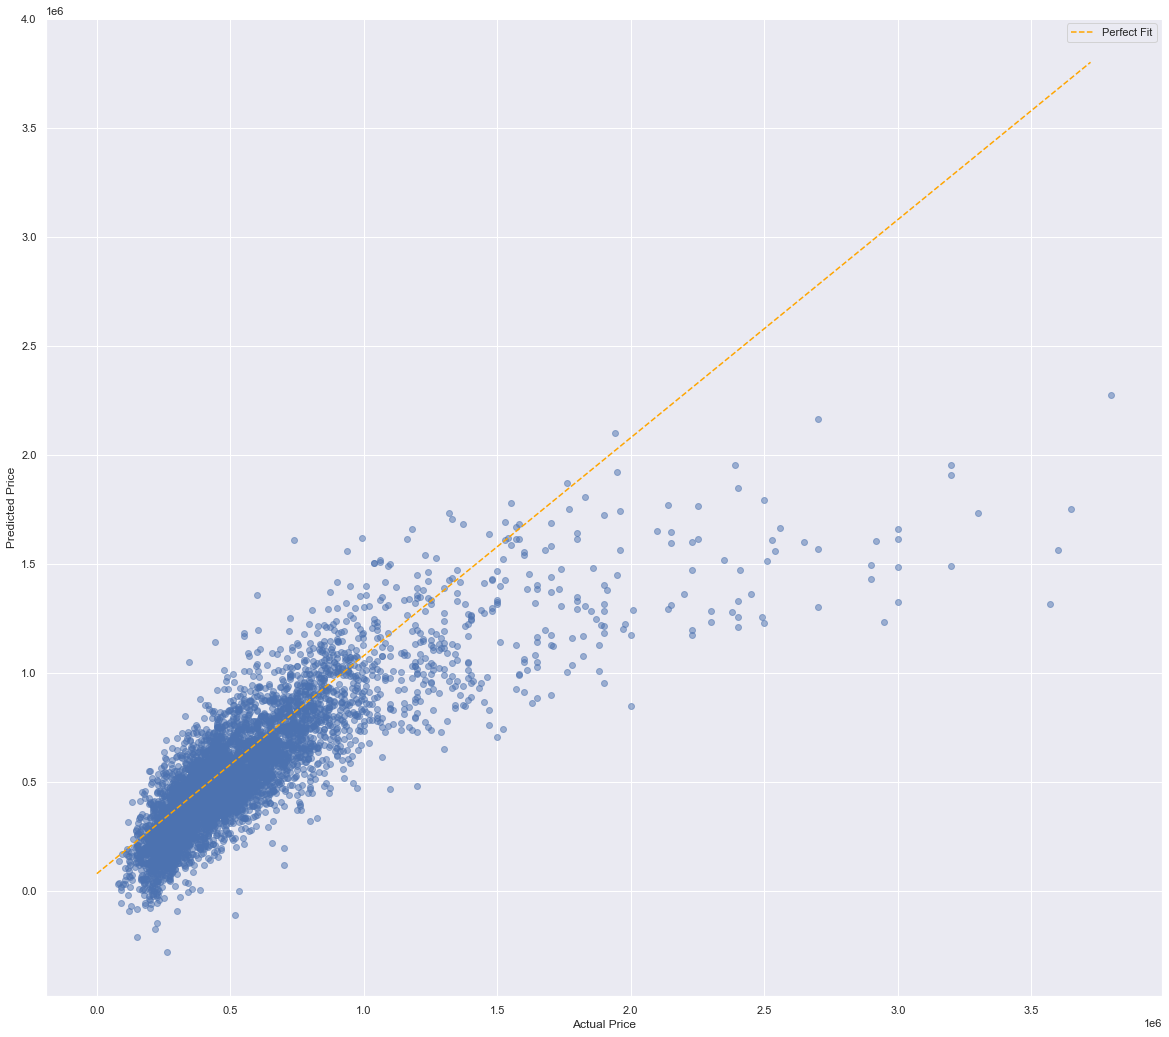

In [106]:
preds = final_model.predict(x_test_final)
fig, ax = plt.subplots(figsize=(20, 18))

perfect_line = np.arange(y_test.min(), y_test.max())
ax.plot(perfect_line, linestyle="--", color="orange", label="Perfect Fit")
ax.scatter(y_test, preds, alpha=0.5)
# ax.set_facecolor("white")
ax.set_xlabel("Actual Price")
ax.set_ylabel("Predicted Price")
ax.legend();

## looks like we have a linear relationship

### Investigating Normality

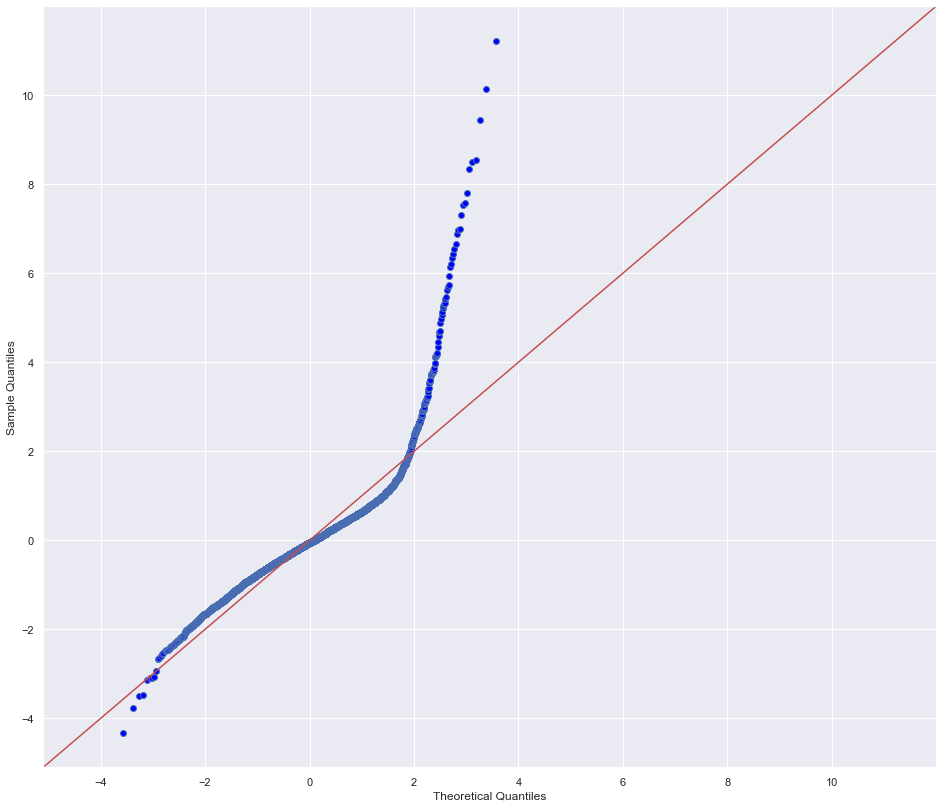

In [107]:
residuals = (y_test - preds)
sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True);

## Outliers violating normality

###  Investigating Multicollinearity

In [108]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = [variance_inflation_factor(x_train_final.values, i) for i in range(x_train_final.shape[1])]
pd.Series(vif, index=x_train_final.columns, name="Variance Inflation Factor")

## there is multicollinearity problem

bedrooms         2.253853e+01
bathrooms        2.602540e+01
sqft_living      8.608045e+02
grade            1.458572e+02
sqft_above       6.411087e+02
sqft_basement    4.513684e+01
yr_built         7.629507e+03
zipcode          1.532596e+06
lat              1.340724e+05
long             1.294945e+06
sqft_living15    2.536054e+01
Name: Variance Inflation Factor, dtype: float64

### Investigating Homoscedasticity

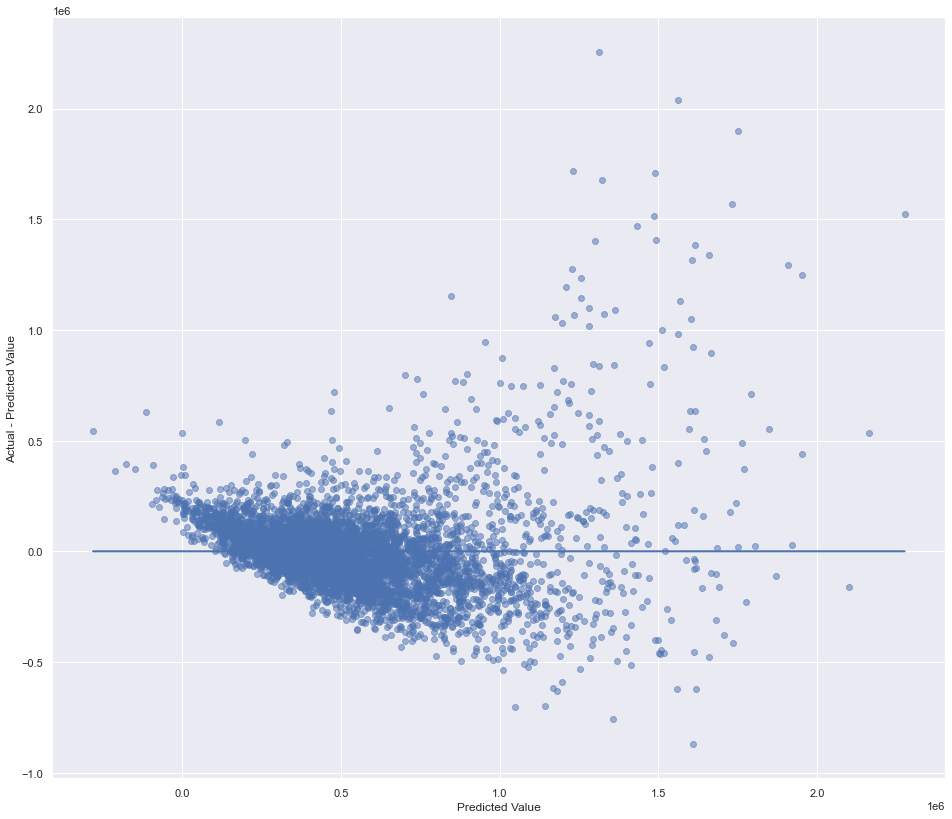

In [109]:
fig, ax = plt.subplots()

ax.scatter(preds, residuals, alpha=0.5)
ax.plot(preds, [0 for i in range(len(x_test))])
ax.set_xlabel("Predicted Value")
ax.set_ylabel("Actual - Predicted Value");

## violating homoscedasticity